In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.naive_bayes import BernoulliNB # Naive Gaus
from sklearn.preprocessing import OneHotEncoder # Conditional Probability 
from sklearn.metrics import confusion_matrix, classification_report # Confusion Matrix
from sklearn.feature_extraction import DictVectorizer
import shap
import seaborn as sns
from itertools import product

In [2]:
# Setup
df = pd.read_csv('Mental_Health_dataset1.csv')
df.drop('SocialWeakness.1', axis=1, inplace=True)
DropCountries = ['Bosnia and Herzegovina', 'Brazil', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Israel', 'Italy', 'Mexico', 'Moldova', 'Nigeria', 'Philippines', 'Portugal', 'Russia', 'Singapore', 'Switzerland', 'Thailand']
df = df[~df['Country'].isin(DropCountries)]
df.dropna()
df.describe()

,Gender,Country,Occupation,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,HabitsChange,MentalHealthHistory,IncreasingStress,MoodSwings,SocialWeakness,CopingStruggles,WorkInterest,MentalHealthInterview,CareOptions
count,240534,240534,240534,236178,240534,240534,240534,240534,240534,240534,240534,240534,240534,240534,240534,240534
unique,2,12,5,2,2,2,5,3,3,3,3,3,2,3,3,3
top,Male,USA,Housewife,No,No,Yes,1-14 days,Yes,No,Maybe,Medium,Maybe,No,No,No,No
freq,209820,154478,55275,213894,146505,123306,52952,89865,86456,83346,82982,85797,127969,86890,191273,97680


In [3]:
# Add Mental Health Problems Binary Column
# If Treatment or MentalHealthHistory or MentalHealthInterview = 1, Then Mental Health Problems = 1
df['MentalHealthIssues'] = np.where((df['MentalHealthHistory'] == 'Yes') | (df['MentalHealthInterview'] == 'Yes') | (df['Treatment'] == 'Yes'), 1, 0)

In [4]:
# Conditional Probability Setter Upper
categorical_features = ['Gender', 'Occupation', 'Country', 'SelfEmployed', 'FamilyHistory', 'HabitsChange', 'IncreasingStress', 'MoodSwings', 'SocialWeakness', 'CopingStruggles', 'WorkInterest']
encoder = OneHotEncoder(sparse_output=False, max_categories=10).set_output(transform='pandas') # Check with no max categories
df_ef = encoder.fit_transform(df[categorical_features])
#df_ef = pd.DataFrame(encoded_features)
#df_ef.iloc[1]
df_ef

,Gender_Female,Gender_Male,Occupation_Business,Occupation_Corporate,Occupation_Housewife,Occupation_Others,Occupation_Student,Country_Australia,Country_Canada,Country_India,...,MoodSwings_Low,MoodSwings_Medium,SocialWeakness_Maybe,SocialWeakness_No,SocialWeakness_Yes,CopingStruggles_No,CopingStruggles_Yes,WorkInterest_Maybe,WorkInterest_No,WorkInterest_Yes
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261323,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
261324,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
261325,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
261326,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [5]:
# Train / Test Random Forest
# Variable Setup
Independent_Variables = df_ef.values.reshape(-1, 39)
Dependent_Variable = df[['MentalHealthIssues']].values.reshape(-1,1)
Dependent_Variable = np.ravel(Dependent_Variable)
# Train Test Datasets
X_train, X_test, y_train, y_test = train_test_split(Independent_Variables, Dependent_Variable, test_size=0.2)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
# Predict
y_pred_RandomForest = rfc.predict(X_test)
Val = (y_test != y_pred_RandomForest).sum() / X_test.shape[0]
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred_RandomForest).sum()))
print(f"By percentage: {1 - Val}")

Number of mislabeled points out of a total 48107 points : 11507
By percentage: 0.7608040409919554


In [6]:
# Accuracy / Precision / Recall / F1 Score
accuracy_rfc = metrics.accuracy_score(y_test, y_pred_RandomForest)
precision_rfc = metrics.precision_score(y_test, y_pred_RandomForest)
recall_rfc = metrics.recall_score(y_test, y_pred_RandomForest)
f1_rfc = metrics.f1_score(y_test, y_pred_RandomForest)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_RandomForest).ravel()
print("Accuracy:", accuracy_rfc)
print("Precision Score:", precision_rfc)
print("Recall Score: ", recall_rfc)
print("F1 Score: ", f1_rfc)
print("False Positive Rate: ", fp/X_test.shape[0])
print("False Negative Rate: ", fn/X_test.shape[0])

Accuracy: 0.7608040409919554
Precision Score: 0.8373597231654862
Recall Score:  0.7998764287920914
F1 Score:  0.8181890000158001
False Positive Rate:  0.10453780115159957
False Negative Rate:  0.134658157856445


In [7]:
# Train / Test Bernoulli Naive Bayes
Independent_Variables = df_ef.values.reshape(-1, 39)
Dependent_Variable = df[['MentalHealthIssues']].values.reshape(-1,1)
Dependent_Variable = np.ravel(Dependent_Variable)
# Train Test Datasets
X_train, X_test, y_train, y_test = train_test_split(Independent_Variables, Dependent_Variable, test_size=0.2)
bnb = BernoulliNB()
model = bnb.fit(X_train, y_train)
y_pred_Bernoulli = bnb.predict(X_test)
# Mislabeled Points
Val = (y_test != y_pred_Bernoulli).sum() / X_test.shape[0]
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred_Bernoulli).sum()))
print(f"By percentage: {1 - Val}")
# Accuracy / Precision / Recall / F1 Score
accuracy_rfc = metrics.accuracy_score(y_test, y_pred_Bernoulli)
precision_rfc = metrics.precision_score(y_test, y_pred_Bernoulli)
recall_rfc = metrics.recall_score(y_test, y_pred_Bernoulli)
f1_rfc = metrics.f1_score(y_test, y_pred_Bernoulli)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_Bernoulli).ravel()
print("Accuracy:", accuracy_rfc)
print("Precision Score:", precision_rfc)
print("Recall Score: ", recall_rfc)
print("F1 Score: ", f1_rfc)
print("False Positive Rate: ", fp/X_test.shape[0])
print("False Negative Rate: ", fn/X_test.shape[0])

Number of mislabeled points out of a total 48107 points : 17542
By percentage: 0.6353545222109049
Accuracy: 0.6353545222109048
Precision Score: 0.7652998885974054
Recall Score:  0.6591760299625468
F1 Score:  0.7082848305451159
False Positive Rate:  0.13575986862618747
False Negative Rate:  0.22888560916290768


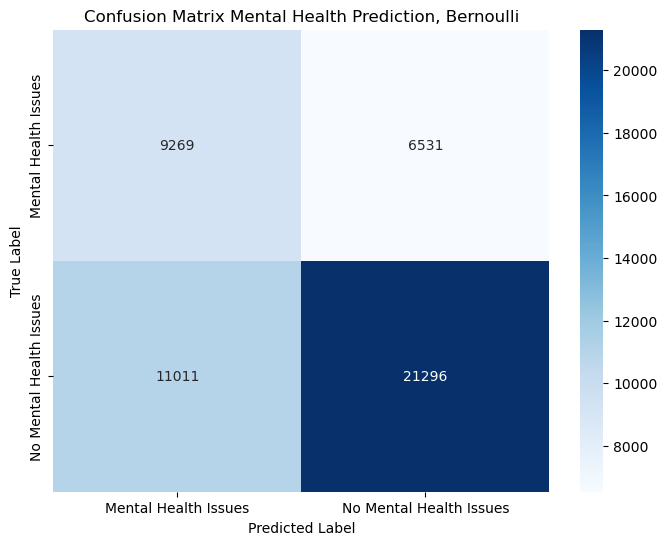

Report
                         precision    recall  f1-score   support

   Mental Health Issues       0.46      0.59      0.51     15800
No Mental Health Issues       0.77      0.66      0.71     32307

               accuracy                           0.64     48107
              macro avg       0.61      0.62      0.61     48107
           weighted avg       0.66      0.64      0.64     48107



In [22]:
# Plot Bernoulli
# Confusion Matrix Metrics
def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mental Health Issues', 'No Mental Health Issues'], yticklabels=['Mental Health Issues', 'No Mental Health Issues'])
    plt.title('Confusion Matrix Mental Health Prediction, Bernoulli')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("Report")
    print(classification_report(y_true, y_pred, target_names=['Mental Health Issues', 'No Mental Health Issues']))

plot_confusion(y_test, y_pred_Bernoulli)

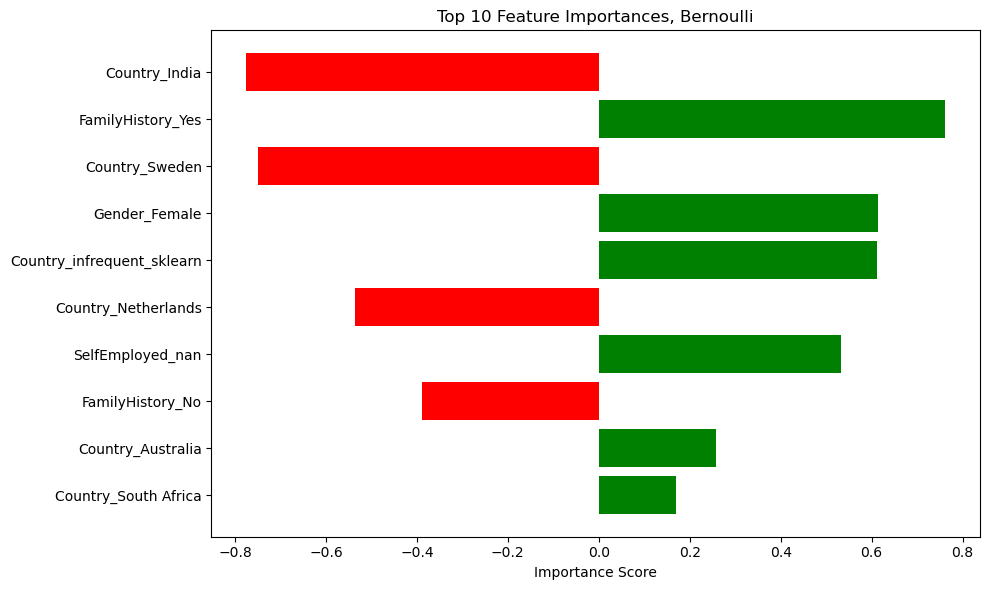

In [28]:
# Bernoulli Information
log_prob_ratio = bnb.feature_log_prob_[1] - bnb.feature_log_prob_[0]
feature_imp_df = pd.DataFrame({'feature' : feature_names, 'importance' : log_prob_ratio})

feature_imp_df['abs_importance'] = np.abs(feature_imp_df['importance'])
top_features = feature_imp_df.nlargest(10, 'abs_importance')

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in top_features['importance']]
plt.title("Top 10 Feature Importances, Bernoulli")
plt.barh(range(10), top_features['importance'][:10], color=colors)
plt.yticks(range(10), top_features['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

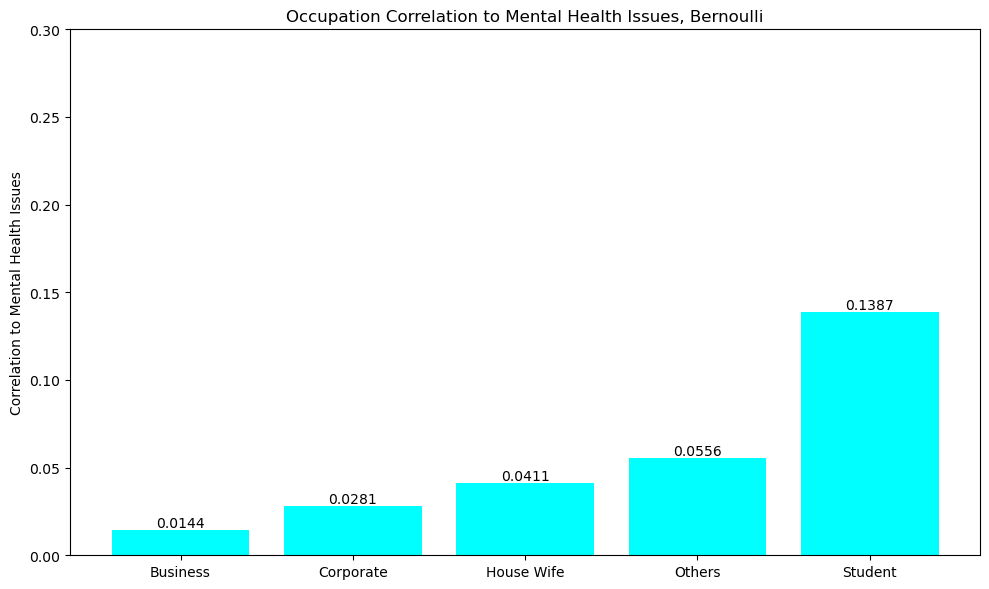

In [58]:
# Bernoulli Occupation Stressors
occupation_imp = feature_imp_df[feature_imp_df['feature'].isin(['Occupation_Business', 'Occupation_Corporate', 'Occupation_Housewife', 'Occupation_Others', 'Occupation_Student'])].copy()
occupation_imp = occupation_imp.sort_values('abs_importance', ascending=True)
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(['Business', 'Corporate', 'House Wife', 'Others', 'Student'], occupation_imp['abs_importance'], color='cyan')
ax.set_title("Occupation Correlation to Mental Health Issues, Bernoulli")
#plt.bar(['Business', 'Corporate', 'House Wife', 'Others', 'Student'], [data_dict['Occupation_Business'], data_dict['Occupation_Corporate'], data_dict['Occupation_Housewife'], data_dict['Occupation_Others'],data_dict['Occupation_Student']])
ax.set_ylim(0,0.3)
plt.ylabel("Correlation to Mental Health Issues")
plt.tight_layout()
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')
plt.show()

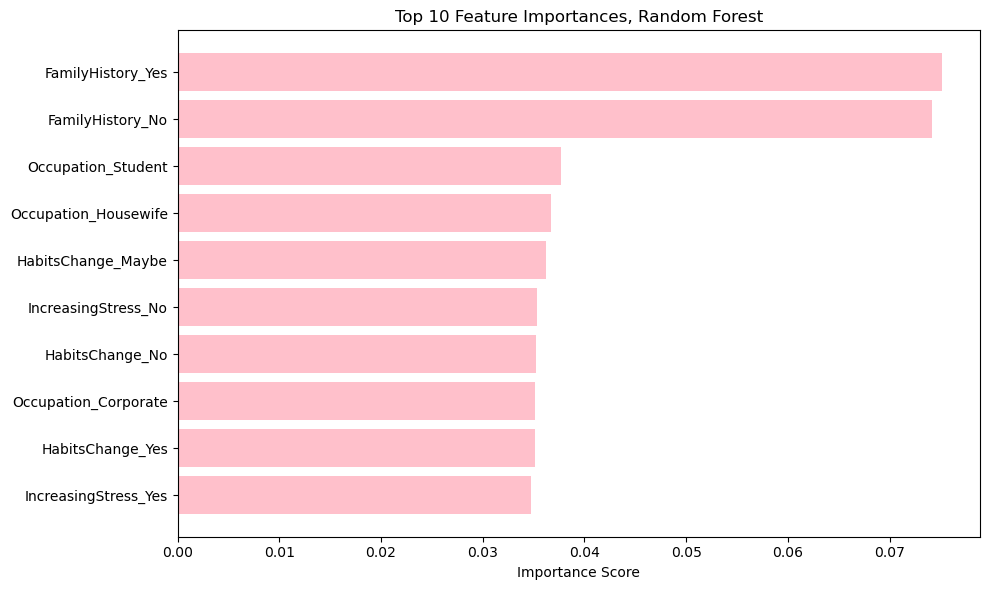

In [30]:
# Random Forest Information
importances = rfc.feature_importances_
feature_names = df_ef.columns.to_list()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances, Random Forest")
plt.barh(range(10), importances[indices][:10], color='pink')
plt.yticks(range(10), [feature_names[i] for i in indices[:10]])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [11]:
# Tree Explainer
#explainer = shap.TreeExplainer(rfc)
#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values[1], X_test, plot_type="dot")

In [12]:
df_cols = df_ef.columns.to_list()
df_important = list(rfc.feature_importances_)
data_dict = {}
i = 0
for item in df_cols:
    data_dict[item] = df_important[i]
    i += 1
data_dict

{'Gender_Female': np.float64(0.013032093937983238),
 'Gender_Male': np.float64(0.012843967089174412),
 'Occupation_Business': np.float64(0.03438511680189404),
 'Occupation_Corporate': np.float64(0.035169568078717066),
 'Occupation_Housewife': np.float64(0.03667496598419604),
 'Occupation_Others': np.float64(0.030769545266232566),
 'Occupation_Student': np.float64(0.03767833730436162),
 'Country_Australia': np.float64(0.006999858819465507),
 'Country_Canada': np.float64(0.01704269214209599),
 'Country_India': np.float64(0.005388014541018549),
 'Country_Ireland': np.float64(0.01694237948153875),
 'Country_Netherlands': np.float64(0.00923777717312651),
 'Country_South Africa': np.float64(0.004922381093623342),
 'Country_Sweden': np.float64(0.004583162782517881),
 'Country_UK': np.float64(0.018329831466529934),
 'Country_USA': np.float64(0.016273680342893945),
 'Country_infrequent_sklearn': np.float64(0.008631871592415711),
 'SelfEmployed_No': np.float64(0.013946401352007374),
 'SelfEmploy

In [13]:
print(f"{data_dict['Occupation_Business']} {data_dict['Occupation_Corporate']} {data_dict['Occupation_Housewife']} {data_dict['Occupation_Others']} {data_dict['Occupation_Student']}")

0.03438511680189404 0.035169568078717066 0.03667496598419604 0.030769545266232566 0.03767833730436162


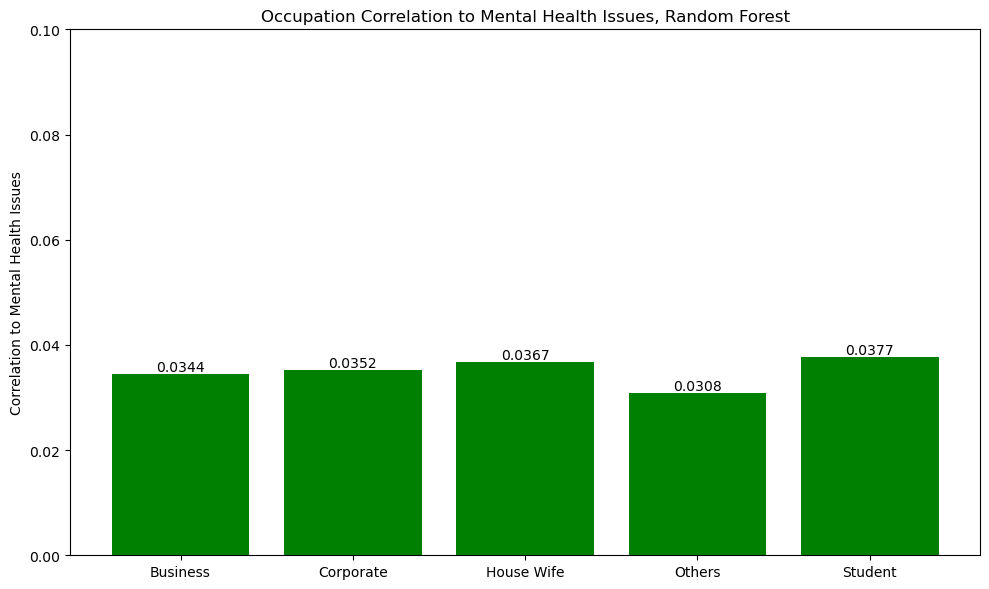

In [29]:
# Plot Occupation Correlation to Stress Data, Random Forest
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(['Business', 'Corporate', 'House Wife', 'Others', 'Student'], [data_dict['Occupation_Business'], data_dict['Occupation_Corporate'], data_dict['Occupation_Housewife'], data_dict['Occupation_Others'],data_dict['Occupation_Student']], color='green')
ax.set_title("Occupation Correlation to Mental Health Issues, Random Forest")
#plt.bar(['Business', 'Corporate', 'House Wife', 'Others', 'Student'], [data_dict['Occupation_Business'], data_dict['Occupation_Corporate'], data_dict['Occupation_Housewife'], data_dict['Occupation_Others'],data_dict['Occupation_Student']])
ax.set_ylim(0,0.1)
plt.ylabel("Correlation to Mental Health Issues")
plt.tight_layout()
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')
plt.show()

In [15]:
print('Gender', 'Occupation', 'Country', 'SelfEmployed', 'FamilyHistory', 'HabitsChange', 'IncreasingStress', 'MoodSwings', 'SocialWeakness', 'CopingStruggles', 'WorkInterest')

Gender Occupation Country SelfEmployed FamilyHistory HabitsChange IncreasingStress MoodSwings SocialWeakness CopingStruggles WorkInterest


In [16]:
df['Country'].unique()

array(['UK', 'USA', 'Canada', 'New Zealand', 'Australia', 'Poland',
       'South Africa', 'Ireland', 'Belgium', 'Netherlands', 'India',
       'Sweden'], dtype=object)